## Goal: make side by side panels of RT'ed images and particle maps

In [1]:
# Okay first remember how to get particle maps:
import requests
import yt
from astropy.cosmology import Planck15
print(yt.__version__)
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib
import pandas as pd
import random
from matplotlib.offsetbox import AnchoredText

baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"3b865713af85f5da0dba3b577e289484"}


def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r

4.0.1


In [2]:
# 
import os
os.listdir('SKIRT_files/')

['output50_41130',
 'output50_110864',
 'output84_357527',
 'output50_79621',
 'output84_275477',
 'output84_300739',
 'output84_116308',
 'output84_242148',
 'output84_129693',
 'output84_378743',
 'output84_332766',
 'output50_85']

In [ ]:
redshift_dict = {'84':0.2,'50':1}

snap = '84'
redshift = redshift_dict[snap]
id = 332766

{'sublink_progenitor': 'http://www.tng-project.org/api/TNG50-1/snapshots/83/subhalos/326686/', 'sublink_descendant': 'http://www.tng-project.org/api/TNG50-1/snapshots/85/subhalos/341875/', 'parent_halo': 'http://www.tng-project.org/api/TNG50-1/snapshots/84/halos/44/'}
{'sublink_progenitor': 'http://www.tng-project.org/api/TNG50-1/snapshots/84/subhalos/332766/', 'sublink_descendant': 'http://www.tng-project.org/api/TNG50-1/snapshots/86/subhalos/344177/', 'parent_halo': 'http://www.tng-project.org/api/TNG50-1/snapshots/85/halos/45/'}
{'sublink_progenitor': 'http://www.tng-project.org/api/TNG50-1/snapshots/85/subhalos/341875/', 'sublink_descendant': 'http://www.tng-project.org/api/TNG50-1/snapshots/87/subhalos/347435/', 'parent_halo': 'http://www.tng-project.org/api/TNG50-1/snapshots/86/halos/45/'}
{'sublink_progenitor': 'http://www.tng-project.org/api/TNG50-1/snapshots/86/subhalos/344177/', 'sublink_descendant': 'http://www.tng-project.org/api/TNG50-1/snapshots/88/subhalos/349567/', 'par

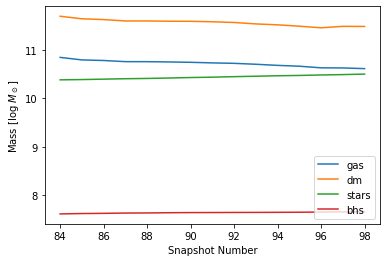

In [9]:

url = "http://www.tng-project.org/api/TNG50-1/snapshots/"+str(snap)+"/subhalos/" + str(id)

sub = get(url) # get json response of subhalo properties
# prepare dict to hold result arrays
fields = ['snap','id','mass_gas','mass_stars','mass_dm','mass_bhs']
r = {}
for field in fields:
    r[field] = []
    
while sub['desc_sfid'] != -1:
    for field in fields:
        r[field].append(sub[field])
    # request the full subhalo details of the descendant by following the sublink URL
    print(sub['related'])
    sub = get(sub['related']['sublink_descendant'])
    
    
plt.clf()
# make a plot (notice our subhalo falls into a much more massive halo around snapshot 105)
for partType in ['gas','dm','stars','bhs']:
    mass_logmsun = np.log10( np.array(r['mass_'+partType])*1e10/0.704)
    plt.plot(r['snap'],mass_logmsun,label=partType)

plt.xlabel('Snapshot Number')
plt.ylabel('Mass [log $M_\odot$]')
plt.legend(loc='lower right')
plt.show()
#savefig('merger_history_'+str(snapshot)+'_'+str(id)+'.png', dpi=1000)

In [33]:
def plot_particles(snap, id, size_box_kpc, res):


    cutout_request_stars = {'stars':'all'}

    sub_url = "http://www.tng-project.org/api/TNG50-1/snapshots/"+str(snap)+"/subhalos/"+str(id)+"/"
    cutout = get(sub_url+"cutout.hdf5",cutout_request_stars)
    
    ds = yt.load(cutout)


    c = ds.arr([sub['pos_x'], sub['pos_y'], sub['pos_z']], "code_length")
    
    # Optionally also show the rgb plot
    direction = 'z'

    kpc_arcsec = Planck15.kpc_proper_per_arcmin(redshift).value/60

    # Now, for a 20x20 kpc box how many pixels?

    num_pix = int(size_box_kpc/(res*kpc_arcsec))


    p2 = yt.FITSParticleProjection(ds, direction, [("PartType4","particle_mass")], width=(size_box_kpc, "kpc"), 
                        image_res=num_pix, center=c)#, deposition='cic'

    particles = np.nan_to_num(p2["particle_mass"].data.d)
    return particles, num_pix



In [ ]:
import astropy.io.fits as fits

#print(os.listdir('SKIRT_files'))
redshift_dict = {'50':1,'84':0.2}

view = 1

for folder in os.listdir('SKIRT_files'):
    # First, get the redshift from the snap
    second = str.split(folder,'output')[1]
    snap = str.split(second, '_')[0]
    id = str.split(second,'_')[1]
    z = redshift_dict[snap]
    
    print(snap, z, id)
    size_box_kpc = 60/(1+z)
    print('size box', size_box_kpc)
    
    res = 0.031 # same as the blue channels
    
    particles, num_pix = plot_particles(snap, id, size_box_kpc, res)
    plt.clf()
    plt.imshow(particles)
    plt.show()
    STOP

    plt.clf()
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(131)
    ax.imshow(particles, interpolation='nearest', norm=matplotlib.colors.LogNorm())#vmax=np.max(particles)/2))
    ax.set_yticks([0, num_pix/2, num_pix])
    ax.set_yticklabels([-size_box_kpc/2, 0, size_box_kpc/2])
    ax.set_ylabel('kpc')
    ax.set_title('Stellar particles')
    #plt.annotate(r'snap = '+str(snap)+', $z = $'+str(round(redshift,4))+', ID = '+str(id), xy=(0.02, 0.93), xycoords='axes fraction', size=17, color='black')
    #mass_logmsun = np.log10( np.array(r['mass_stars'][j])*1e10/0.704)
    #plt.annotate(r'log $M_* = $'+str(round(mass_logmsun,2)), xy=(0.02, 0.85), xycoords='axes fraction', size=17, color='black')

    #plt.title('Snap = '+str(snapshot)+' z = '+str(round(redshift,4))+' ID = '+str(id))
    
    
    
    try:
        im = fits.open('SKIRT_files/'+folder+'/'+'dusty_img'+str(view)+'_total.fits')
    except FileNotFoundError:
        continue
    ax1 = fig.add_subplot(132)
    ax1.imshow(np.sum(im[0].data, axis=0), norm=matplotlib.colors.LogNorm())
    print(folder)
    ax1.set_title(r'\texttt{SKIRT}\nBolometric Surface Brightness')
    ax1.axis('off')
    
    npy_file = np.load('mock_images/redshift_'+str(z)+'/'+str(id)+'/'+str(id)+'_'+str(view)+'.npy', allow_pickle=True)
    
    ax2 = fig.add_subplot(133)
    ax2.imshow(abs(npy_file[5]), norm=matplotlib.colors.LogNorm())
    ax2.set_title('Observational Realism')
    ax2.axis('off')
    plt.show()

50 1 41130
size box 30.0
